In [1]:
!pip install scikeras

In [2]:
!pip install tensorflow-addons

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History
from scikeras.wrappers import KerasClassifier
from google.colab import drive
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import tensorflow as tf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_size = 0.9
epochs = 200
batch_size = 16
learning_rate = 0.0001
validation_split = 0.1
patience = 10

model_arch = 'complex' # simple or complex
if model_arch == 'complex':
    first_layer_neurons = 256 # complex
else:
    first_layer_neurons = 64 # simple

top_features_drop = 'yes' # yes or no
if top_features_drop == 'yes':
    top_features_count = 45 # yes
else:
    top_features_count = 10 # no

# start_index = 35
# end_index = start_index + 10

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    f1 = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
    return f1

# metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(num_classes=3, average='macro')]
metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

In [6]:
def build_model(input_dim, output_units):
  if model_arch == 'complex':
      print("\n Building complex model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(64, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(dropout_rate))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

  if model_arch == 'simple':
      print("\n Building simple model")
      model = Sequential()
      model.add(Dense(first_layer_neurons, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.2))

      model.add(Dense(16, activation='relu'))
      # model.add(Dropout(0.2))

      model.add(Dense(output_units, activation='softmax'))  # Final output layer
      return model

# **Top features**

In [7]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')
data

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,dTos_missing,dTtl_missing,dHops_missing,SrcGap_missing,DstGap_missing,SrcWin_missing,DstWin_missing,SrcTCPBase_missing,DstTCPBase_missing,SliceType
0,34555.000000,982.000000,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224.0,...,0,0,0,1,1,1,1,1,1,URLLC
1,531568.000000,11362.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.0,...,1,1,1,1,1,1,1,1,1,URLLC
2,360399.000000,70834.000000,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0.0,...,1,1,1,1,1,1,1,1,1,URLLC
3,30702.000000,440.000000,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0.0,...,0,0,0,1,1,1,1,1,1,URLLC
4,312747.000000,128397.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.0,...,1,1,1,1,1,1,1,1,1,URLLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,455292.377185,281.829734,3.620188,3.961441,3.642492,4.080528,3.689328,3.684907,3,0.0,...,0,0,0,0,0,0,0,0,0,mMTC
14452,455262.025767,298.318232,4.376486,2.966175,3.594366,3.873222,3.280655,3.083385,3,0.0,...,0,0,0,0,0,0,0,0,0,mMTC
14453,455286.246951,293.324452,3.818366,3.667252,4.340313,4.514485,3.882577,4.103266,3,0.0,...,0,0,0,0,0,0,0,0,0,mMTC
14454,455211.102576,171.202752,4.414447,4.101491,4.156414,4.301263,4.173065,4.550792,3,0.0,...,0,0,0,0,0,0,0,0,0,mMTC


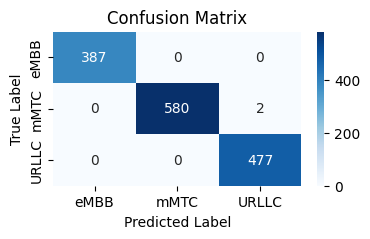

              precision    recall  f1-score   support

       URLLC     1.0000    1.0000    1.0000       387
        eMBB     1.0000    0.9966    0.9983       582
        mMTC     0.9958    1.0000    0.9979       477

    accuracy                         0.9986      1446
   macro avg     0.9986    0.9989    0.9987      1446
weighted avg     0.9986    0.9986    0.9986      1446



In [8]:
df = data.copy()

X = df.drop('SliceType', axis=1)
y = df['SliceType']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
# y_pred

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, digits=4))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

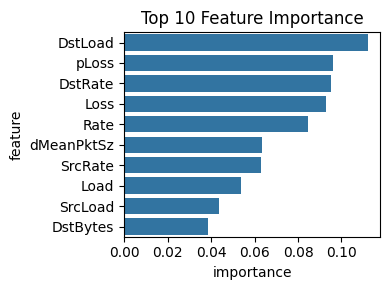


Top 10 Important Features:
       feature  importance
29     DstLoad    0.112119
33       pLoss    0.096066
38     DstRate    0.095306
30        Loss    0.092973
36        Rate    0.084405
26  dMeanPktSz    0.063268
37     SrcRate    0.062805
27        Load    0.053849
28     SrcLoad    0.043680
23    DstBytes    0.038704


In [9]:
# Plot feature importance
plt.figure(figsize=(4,3))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

## Drop features

In [10]:
X.head()

,X,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,UniqueID,dTos_missing,dTtl_missing,dHops_missing,SrcGap_missing,DstGap_missing,SrcWin_missing,DstWin_missing,SrcTCPBase_missing,DstTCPBase_missing
0,34555.0,982.0,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,4,224.0,...,144379.0,0,0,0,1,1,1,1,1,1
1,531568.0,11362.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.0,...,181691.0,1,1,1,1,1,1,1,1,1
2,360399.0,70834.0,2.560251,2.560251,2.560251,2.560251,2.560251,2.560251,4,0.0,...,175580.0,1,1,1,1,1,1,1,1,1
3,30702.0,440.0,0.046014,0.046014,0.046014,0.046014,0.046014,0.046014,4,0.0,...,120239.0,0,0,0,1,1,1,1,1,1
4,312747.0,128397.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0.0,...,348612.0,1,1,1,1,1,1,1,1,1


In [11]:
top_features = feature_importance['feature'].head(top_features_count).tolist()
# top_features = feature_importance['feature'][start_index:end_index].tolist()
print(top_features)

['DstLoad', 'pLoss', 'DstRate', 'Loss', 'Rate', 'dMeanPktSz', 'SrcRate', 'Load', 'SrcLoad', 'DstBytes', 'SrcBytes', 'TotBytes', 'SrcWin', 'DstPkts', 'TotPkts', 'SrcPkts', 'SrcWin_missing', 'SrcLoss', 'SrcGap_missing', 'DstWin', 'SrcTCPBase_missing', 'Dur', 'dDSb', 'Min', 'RunTime', 'State', 'sMeanPktSz', 'DstWin_missing', 'UniqueID', 'DstGap_missing', 'Proto', 'dTtl_missing', 'Max', 'AckDat', 'Mean', 'DstTCPBase_missing', 'DstLoss', 'TcpRtt', 'Sum', 'dTos_missing', 'Seq', 'dHops_missing', 'SynAck', 'Offset', 'dTtl']


In [12]:
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X = X.drop(top_features, axis=1)
X.head()


 Dropping top features


,X,sTos,dTos,sDSb,sTtl,sHops,dHops,Cause,SrcGap,DstGap,SrcTCPBase,DstTCPBase
0,34555.0,224.0,184.000000,6,250.0,6.0,1.000000,1,0.0,0.0,3.904204e+09,3.704605e+09
1,531568.0,0.0,0.257735,4,249.0,7.0,5.931325,1,0.0,0.0,1.836252e+09,2.446250e+09
2,360399.0,0.0,0.257735,4,63.0,1.0,5.931325,2,0.0,0.0,1.836252e+09,2.446250e+09
3,30702.0,0.0,0.000000,4,64.0,0.0,11.000000,2,0.0,0.0,9.797546e+07,3.508802e+09
4,312747.0,0.0,0.257735,4,63.0,1.0,5.931325,1,0.0,0.0,1.836252e+09,2.446250e+09



 Traning Latency RFC: 0.5310652256011963 seconds


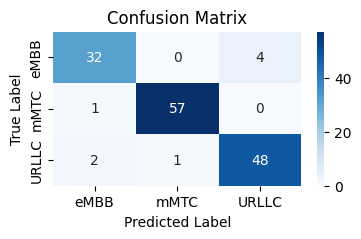

              precision    recall  f1-score   support

       URLLC     0.9143    0.8889    0.9014        36
        eMBB     0.9828    0.9828    0.9828        58
        mMTC     0.9231    0.9412    0.9320        51

    accuracy                         0.9448       145
   macro avg     0.9400    0.9376    0.9387       145
weighted avg     0.9448    0.9448    0.9447       145



In [13]:
# Removing 80% of the data
X_temp, X_drop, y_temp, y_drop = train_test_split(X, y, test_size=test_size, random_state=42)

# Split the 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=validation_split, random_state=42)

# Train a Random Forest model
rf_model_no_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
start_time_rfc = time.time()
rf_model_no_top_features.fit(X_train, y_train)
end_time_rfc = time.time()
latency_rfc = end_time_rfc - start_time_rfc
print(f"\n Traning Latency RFC: {latency_rfc} seconds")

# Make predictions
y_pred = rf_model_no_top_features.predict(X_test)
# y_pred

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['eMBB', 'mMTC', 'URLLC'], yticklabels=['eMBB', 'mMTC', 'URLLC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, digits=4))

In [14]:

# # Feature importance
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf_model_no_top_features.feature_importances_
# }).sort_values('importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(8,6))
# sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
# plt.title('Top 10 Feature Importance')
# plt.tight_layout()
# plt.show()

# print("\nTop 10 Important Features:")
# print(feature_importance.head(10))

# **5G Slice Ndd Dataset with Standalone Neural Network**

In [15]:
# Load the preprocessed dataset
data3 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')

# Separate features and target
X3 = data3.drop('SliceType', axis=1)
y3 = data3['SliceType']

# Drop top features if specified
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X3 = X3.drop(top_features, axis=1)

# Encode target labels
le = LabelEncoder()
y3_encoded = le.fit_transform(y3)
y3 = to_categorical(y3_encoded)

# Scale features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the features
X3_scaled = scaler.fit_transform(X3)
# X3_scaled = X3

# Convert back to DataFrame for easier handling
X3 = pd.DataFrame(X3_scaled, columns=X3.columns)

# Split the data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=test_size, random_state=42)

###############################################################################################################
# Build the neural network model
input_dim = X3.shape[1]
output_units = y3.shape[1]

model3 = build_model(input_dim, output_units)

###############################################################################################################

# Compile the model with custom metrics
# model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1_score])
model3.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Create a history object to store training metrics
history3 = History()

# Evaluate the model
loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
print(f"Test Accuracy before training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")

# start time
start_time_neural_network = time.time()

# Train the model with early stopping and history callbacks
model3.fit(X3_train, y3_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping, history3])

# end time
end_time_neural_network = time.time()

latency_neural_network = end_time_neural_network - start_time_neural_network
print(f"\n Standalone Neural Network --- Latency: {latency_neural_network} seconds - Training Accuracy: {history3.history['accuracy'][-1]:.4f} - Validation Accuracy: {history3.history['val_accuracy'][-1]:.4f} \n")

# Evaluate the model
loss3, accuracy3, recall3, precision3 = model3.evaluate(X3_test, y3_test)
print(f"Test Accuracy after training: {accuracy3:.4f} - Test Loss: {loss3:.4f} - Test Recall: {recall3:.4f} - Test Precision: {precision3:.4f}")


 Dropping top features

 Building complex model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3761 - loss: 1.1922 - precision: 0.0355 - recall: 0.0015
Test Accuracy before training: 0.3774 - Test Loss: 1.1901 - Test Recall: 0.0011 - Test Precision: 0.0263
Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3883 - loss: 1.2284 - precision: 0.2189 - recall: 0.0111 - val_accuracy: 0.6483 - val_loss: 1.0084 - val_precision: 0.8000 - val_recall: 0.0552
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5211 - loss: 1.0614 - precision: 0.7112 - recall: 0.0507 - val_accuracy: 0.7241 - val_loss: 0.9673 - val_precision: 0.9130 - val_recall: 0.1448
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5883 - loss: 1.0170 - precision: 0.7404 - recall: 0.0934 - val_accuracy: 0.7241 - val_loss: 0.9133 - val_precision: 0.8333 - val_recall: 0.2069
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6460 - loss: 0.9949 - precision: 0.7246 - recall: 0.1200 - val_accuracy: 0.7241 - val_loss

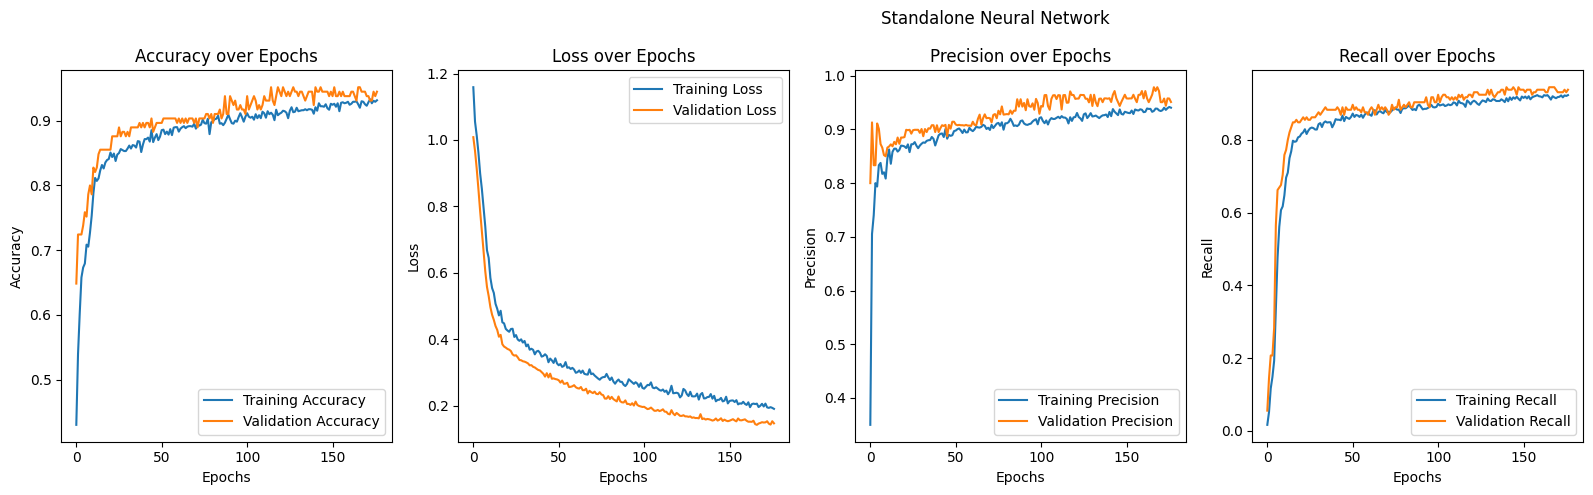

In [16]:
# Retrieve metrics from the history object
train_acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

train_precision3 = history3.history['precision']
val_precision3 = history3.history['val_precision']

train_recall3 = history3.history['recall']
val_recall3 = history3.history['val_recall']

# train_f13 = history3.history['f1_score']
# val_f13 = history3.history['val_f1_score']

# Print metrics for each epoch
# for epoch in range(len(train_acc3)):
#     print(f"Epoch {epoch+1}:")
#     print(f"  Training Accuracy: {train_acc3[epoch]:.4f}, Validation Accuracy: {val_acc3[epoch]:.4f}")
#     print(f"  Training Loss: {train_loss3[epoch]:.4f}, Validation Loss: {val_loss3[epoch]:.4f}")
#     print(f"  Training Precision: {train_precision3[epoch]:.4f}, Validation Precision: {val_precision3[epoch]:.4f}")
#     print(f"  Training Recall: {train_recall3[epoch]:.4f}, Validation Recall: {val_recall3[epoch]:.4f}")
#     print(f"  Training F1 Score: {train_f13[epoch]:.4f}, Validation F1 Score: {val_f13[epoch]:.4f}")


# Plot accuracy and loss over epochs
plt.figure(figsize=(20, 5))
plt.suptitle('Standalone Neural Network')

plt.subplot(1, 5, 1)
plt.plot(train_acc3, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 5, 2)
plt.plot(train_loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 5, 3)
plt.plot(train_precision3, label='Training Precision')
plt.plot(val_precision3, label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(train_recall3, label='Training Recall')
plt.plot(val_recall3, label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# plt.subplot(1, 5, 5)
# plt.plot(train_f13, label='Training F1 Score')
# plt.plot(val_f13, label='Validation F1 Score')
# plt.title('F1 Score over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# # Predict on the test set
# y_pred3 = model3.predict(X3_test)

# # Convert predictions to class labels
# y_pred3_class = np.argmax(y_pred3, axis=1)
# y_test_class = np.argmax(y3_test, axis=1)

# # Calculate precision, recall, and F1 score
# precision = precision_score(y_test_class, y_pred3_class, average='macro')
# recall = recall_score(y_test_class, y_pred3_class, average='macro')
# f1 = f1_score(y_test_class, y_pred3_class, average='macro')

# # Calculate confusion matrix
# conf_mat = confusion_matrix(y_test_class, y_pred3_class)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_mat)

# **Base Model using Neural Network on DeepSlice Dataset**

In [18]:
# Load deepslice_data.csv
data1 = pd.read_csv('/content/drive/MyDrive/Dataset/deepslice_data.csv.zip')

# Data pre-processing
# Feature Conversion - Categorical to Numerical
one_hot_encoded_data1 = pd.get_dummies(data1, columns = ['Day','Use Case', 'Technology Supported', 'GBR'])
data1_ohe = one_hot_encoded_data1.rename(columns={'Day_sunday':'sunday','Day_monday':'monday','Day_tuesday':'tuesday','Day_wednesday':'wednesday','Day_thrusday':'thrusday','Day_friday':'friday','Day_saturday':'saturday','Use Case_AR/VR/Gaming':'AR/VR/Gaming','Use Case_Healthcare':'Healthcare','Use Case_Industry 4.0':'Industry 4.0','Use Case_IoT Devices':'IoT Devices','Use Case_Public Safety':'Public Safety','Use Case_Smart City & Home':'Smart City & Home','Use Case_Smart Transportation':'Smart Transportation','Use Case_Smartphone':'Smartphone','Technology Supported_IoT(LTE-M, NB-IoT)':'IoT','Technology Supported_LTE/5G':'LTE/5G','GBR_GBR':'GBR','GBR_Non-GBR':'Non-GBR'})
data1 = data1_ohe[['LTE/5g Category', 'Time', 'sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', 'Packet Loss Rate', 'Packet delay', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR', 'AR/VR/Gaming',	'Healthcare',	'Industry 4.0', 'IoT Devices',	'Public Safety',	'Smart City & Home',	'Smart Transportation',	'Smartphone', 'slice Type']]

# Replace boolean values with 0 and 1 in specified columns
columns_to_convert = ['sunday', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday', 'saturday', "IoT", "LTE/5G", "GBR", "Non-GBR", "AR/VR/Gaming", "Healthcare", "Industry 4.0", "IoT Devices", "Public Safety", "Smart City & Home", "Smart Transportation", "Smartphone"]
for column in columns_to_convert:
    data1[column] = data1[column].replace({False: 0, True: 1})

data1 = data1.drop_duplicates()

X1 = data1.drop('slice Type', axis=1)
y1 = data1['slice Type']

# Encode target labels if necessary
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)

# Scale features
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_encoded, test_size=0.2, random_state=42)

##################################################################################################
# Create a new model with input layer
input_dim_X1 = X1_scaled.shape[1]
output_units_y1 = len(np.unique(y1_encoded))

# Build the model for X1_scaled and y1_encoded
model1 = build_model(input_dim=input_dim_X1, output_units=output_units_y1)

#################################################################################################

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create a history object to store training metrics
history1 = History()

# start time
start_time_base_model1_training = time.time()

# Train the model on new data
model1.fit(X1_train, y1_train, epochs=10, batch_size=32, validation_split=0.5, callbacks=[early_stopping, history1])

# end time
end_time_base_model1_training = time.time()

latency_base_model1_training = end_time_base_model1_training - start_time_base_model1_training
print(f"\n Latency for base model1 training: {latency_base_model1_training} seconds")

# Evaluate on test set
loss1, accuracy1 = model1.evaluate(X1_test, y1_test)
print(f"Test Accuracy: {accuracy1:.4f}")

# Save the trained model if needed
model1.save('deep_slice_model.h5')

<ipython-input-18-a078db5d0f8a>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data1[column] = data1[column].replace({False: 0, True: 1})
<ipython-input-18-a078db5d0f8a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[column] = data1[column].replace({False: 0, True: 1})



 Building complex model
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5637 - loss: 0.9926 - val_accuracy: 0.8599 - val_loss: 0.6795
Epoch 2/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8082 - loss: 0.5996 - val_accuracy: 0.9244 - val_loss: 0.3084
Epoch 3/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9398 - loss: 0.2832 - val_accuracy: 1.0000 - val_loss: 0.1277
Epoch 4/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9968 - loss: 0.1232 - val_accuracy: 1.0000 - val_loss: 0.0438
Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9996 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9999 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_

Test Accuracy: 1.0000


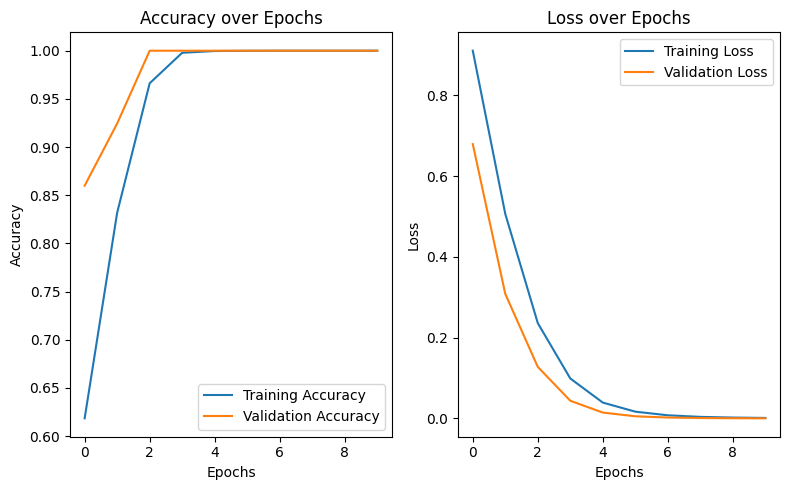

In [19]:
# Retrieve metrics from the history object
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Print metrics for each epoch
# for epoch in range(len(train_acc)):
#     print(f"Epoch {epoch+1}:")
#     print(f"  Training Accuracy: {train_acc[epoch]:.4f}, Validation Accuracy: {val_acc[epoch]:.4f}")
#     print(f"  Training Loss: {train_loss[epoch]:.4f}, Validation Loss: {val_loss[epoch]:.4f}")

# Plot accuracy and loss over epochs
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Transfer Learning on 5G Slice Ndd Dataset**

In [ ]:
# Load deepslice_data.csv
data2 = pd.read_csv('/content/drive/MyDrive/Dataset/5G_SliciNdd_preprocessed.csv')

# Data pre-processing
# Separate features and target
X2 = data2.drop('SliceType', axis=1)
y2 = data2['SliceType']

# Drop top features if specified
if top_features_drop == 'yes':
  print("\n Dropping top features")
  X2 = X2.drop(top_features, axis=1)

# Encode target labels
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)
y2 = to_categorical(y2_encoded)

# Scale features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the features
X2_scaled = scaler.fit_transform(X2)
X2_scaled = X2

# Convert back to DataFrame for easier handling
X2 = pd.DataFrame(X2_scaled, columns=X2.columns)

# Split the data
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = X3_train, X3_test, y3_train, y3_test

##################################################################################################
# Load pre-trained model
model1 = load_model('deep_slice_model.h5')

# Freeze layers if needed
# for layer in model_pt.layers[:-2]:  # Freeze all but last layer
#     layer.trainable = False

# Create a new model with adjusted input layer
model2 = Sequential()

# Add a new input layer with the correct shape
model2.add(Dense(first_layer_neurons, activation='relu', input_shape=(X2_train.shape[1],)))

# Add layers from the pre-trained model (excluding the input layer)
for layer in model1.layers[1:]:
    model2.add(layer)

#################################################################################################

# Compile the model
model2.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=metrics)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Create a history object to store training metrics
history2 = History()

# Evaluate on test set
loss2, accuracy2, recall2, precision2 = model2.evaluate(X2_test, y2_test)
print(f"Test Accuracy Before Training: {accuracy2:.4f}")

# start time
start_time_transfer_learning = time.time()

for epoch in range(int(epochs*1.5)):
  # Train the model on new data
  print(f"\n Epoch: {epoch+1}")
  model2.fit(X2_train, y2_train, epochs=1, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping, history2])

  # end time
  end_time_transfer_learning = time.time()

  latency_transfer_learning = end_time_transfer_learning - start_time_transfer_learning

  print("\n latency_transfer_learning:", latency_transfer_learning, "\t latency_neural_network:", latency_neural_network, "\n")

  # should_stop_training = latency_transfer_learning >= latency_neural_network
  # if should_stop_training:
  #   print("\n Training stopped as latency limit is reached")
  #   break

print(f"\n Transfer Learning --- Latency: {latency_transfer_learning} seconds - Training Accuracy: {history2.history['accuracy'][-1]:.4f} - Validation Accuracy: {history2.history['val_accuracy'][-1]:.4f} \n")
print(f"\n Standalone Neural Network --- Latency: {latency_neural_network} seconds - Training Accuracy: {history3.history['accuracy'][-1]:.4f} - Validation Accuracy: {history3.history['val_accuracy'][-1]:.4f} \n")

# Evaluate on test set
loss2, accuracy2, recall2, precision2 = model2.evaluate(X2_test, y2_test)
print(f"Test Accuracy After Training: {accuracy2:.4f}")


 Dropping top features


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3834 - loss: 4.4950 - precision: 0.7914 - recall: 0.7140
Test Accuracy Before Training: 0.3844

 Epoch: 1
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4039 - loss: 2.6983 - precision: 0.4444 - recall: 0.2527 - val_accuracy: 0.5448 - val_loss: 1.2928 - val_precision: 0.8060 - val_recall: 0.3724

 latency_transfer_learning: 3.0770246982574463 	 latency_neural_network: 97.84934496879578 


 Epoch: 2
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4893 - loss: 1.3575 - precision: 0.5765 - recall: 0.2835 - val_accuracy: 0.6069 - val_loss: 1.0570 - val_precision: 0.7875 - val_recall: 0.4345

 latency_transfer_learning: 3.7808663845062256 	 latency_neural_network: 97.84934496879578 


 Epoch: 3
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5896 - loss: 1.3868 - precision: 0.6864 - recall: 0.3952 - val_accuracy: 0.7172 - val_loss: 0.9830 - val_precision: 0.8023 - val_recall: 0.4759

 latency_transfer_learning: 4.4824554

In [ ]:
# Retrieve metrics from the history object
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

train_precision2 = history2.history['precision']
val_precision2 = history2.history['val_precision']

train_recall2 = history2.history['recall']
val_recall2 = history2.history['val_recall']

# train_f12 = history2.history['f1_score']
# val_f12 = history2.history['val_f1_score']

# Print metrics for each epoch
# for epoch in range(len(train_acc2)):
#     print(f"Epoch {epoch+1}:")
#     print(f"  Training Accuracy: {train_acc2[epoch]:.4f}, Validation Accuracy: {val_acc2[epoch]:.4f}")
#     print(f"  Training Loss: {train_loss2[epoch]:.4f}, Validation Loss: {val_loss2[epoch]:.4f}")
#     print(f"  Training Precision: {train_precision2[epoch]:.4f}, Validation Precision: {val_precision2[epoch]:.4f}")
#     print(f"  Training Recall: {train_recall2[epoch]:.4f}, Validation Recall: {val_recall2[epoch]:.4f}")
#     print(f"  Training F1 Score: {train_f12[epoch]:.4f}, Validation F1 Score: {val_f12[epoch]:.4f}")


# Plot accuracy and loss over epochs
plt.figure(figsize=(20, 5))
plt.suptitle('Transfer Learning')

plt.subplot(1, 5, 1)
plt.plot(train_acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 5, 2)
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 5, 3)
plt.plot(train_precision2, label='Training Precision')
plt.plot(val_precision2, label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 5, 4)
plt.plot(train_recall2, label='Training Recall')
plt.plot(val_recall2, label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# plt.subplot(1, 5, 5)
# plt.plot(train_f12, label='Training F1 Score')
# plt.plot(val_f12, label='Validation F1 Score')
# plt.title('F1 Score over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()

plt.tight_layout()
plt.show()

# **Plot**

In [ ]:
plt.figure(figsize=(8, 6))
# plt.plot(train_acc3, label='Training accuracy - standalone')
plt.plot(val_acc3, label='Validation accuracy - standalone')
# plt.plot(train_acc2, label='Training accuracy - transfer learning')
plt.plot(val_acc2, label='Validation accuracy - transfer learning')
# plt.title('Accuracy over Epochs')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(8, 6))
# plt.plot(train_loss3, label='Training loss - standalone')
plt.plot(val_loss3, label='Validation loss - standalone')
# plt.plot(train_loss2, label='Training loss - transfer learning')
plt.plot(val_loss2, label='Validation loss - transfer learning')
# plt.title('Loss over Epochs')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=14)

In [ ]:
import matplotlib.pyplot as plt

# Data from your table
batch_sizes = [16, 32, 48, 64]

# Latencies (Standalone Network, Transfer Learning)
latency_standalone_00001 = [46.83, 29.56, 24.87, 21.23]  # Learning rate 0.00001
latency_transfer_00001 = [40.11, 27.82, 22.82, 20.48]    # Learning rate 0.00001

latency_standalone_0001 = [47.24, 30.16, 26.17, 25.68]   # Learning rate 0.0001
latency_transfer_0001 = [43.06, 28.22, 23.98, 24.68]     # Learning rate 0.0001

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot for Learning rate 0.00001
ax.plot(batch_sizes, latency_standalone_00001, marker='o', label='Standalone (LR=0.00001)', color='lightblue', linestyle='--')
ax.plot(batch_sizes, latency_transfer_00001, marker='o', label='Transfer Learning (LR=0.00001)', color='blue', linestyle='-')

# Plot for Learning rate 0.0001
ax.plot(batch_sizes, latency_standalone_0001, marker='o', label='Standalone (LR=0.0001)', color='lightgreen', linestyle='--')
ax.plot(batch_sizes, latency_transfer_0001, marker='o', label='Transfer Learning (LR=0.0001)', color='green', linestyle='-')

# Customization
ax.set_xlabel('Batch size', fontsize=14)
ax.set_ylabel('Training latency (s)', fontsize=14)
# ax.set_title('Standalone Network vs Transfer Learning: Latency Comparison')
ax.set_xticks(batch_sizes)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=12)

plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Data from your table
batch_sizes = [16, 32, 48, 64]

# Latencies (Standalone Network, Transfer Learning)
accuracy_standalone_00001 = [93.45, 88.62, 80.69, 75.52]  # Learning rate 0.00001
accuracy_transfer_00001 = [95.17, 93.45, 90.00, 85.86]    # Learning rate 0.00001

accuracy_standalone_0001 = [99.31, 98.97, 97.93, 96.90]   # Learning rate 0.0001
accuracy_transfer_0001 = [99.31, 98.97, 98.62, 98.28]     # Learning rate 0.0001

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot for Learning rate 0.00001
ax.plot(batch_sizes, accuracy_standalone_00001, marker='o', label='Standalone (LR=0.00001)', color='lightblue', linestyle='--')
ax.plot(batch_sizes, accuracy_transfer_00001, marker='o', label='Transfer Learning (LR=0.00001)', color='blue', linestyle='-')

# Plot for Learning rate 0.0001
ax.plot(batch_sizes, accuracy_standalone_0001, marker='o', label='Standalone (LR=0.0001)', color='lightgreen', linestyle='--')
ax.plot(batch_sizes, accuracy_transfer_0001, marker='o', label='Transfer Learning (LR=0.0001)', color='green', linestyle='-')

# Customization
ax.set_xlabel('Batch size', fontsize=14)
ax.set_ylabel('Mean accuracy (%)', fontsize=14)
# ax.set_title('Standalone Network vs Transfer Learning: Latency Comparison')
ax.set_xticks(batch_sizes)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=12)

plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Data
training_size = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
standalone = [84.51, 80.73, 77.16, 78.75, 61.28, 48.85, 48.95, 42.20, 33.80, 28.27]
transfer_learning = [78.45, 74.32, 70.38, 73.07, 58.85, 45.93, 48.71, 38.36, 30.37, 25.17]

plt.subplots(figsize=(8, 6))

# Create the plot
plt.plot(training_size, standalone, label='Standalone', marker='o')
plt.plot(training_size, transfer_learning, label='Transfer Learning', marker='o')

# Add labels and title
plt.xlabel('Training size (%)', fontsize=14)
plt.ylabel('Training latency (s)', fontsize=14)
# plt.title('Standalone vs Transfer Learning Performance')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(range(10, 101, 10))
plt.yticks(range(0, 101, 10))
plt.grid(True)

# Add legend
plt.legend(fontsize=14)

# Reverse the x-axis so the values decrease from left to right
plt.gca().invert_xaxis()

# Show the plot
plt.show()

In [ ]:
%cp '/content/drive/MyDrive/Colab Notebooks/Exp16_Deep_Slice_NSI_Transfer_Learning.ipynb' '/content/drive/MyDrive/Network_Slicing_with_ML_repo/Network-Slicing-with-ML/Notebooks/'

# **SYNC NOTEBOOKS**

In [ ]:
%cp '/content/drive/MyDrive/Colab Notebooks/Exp17_Deep_Slice_NSI_Transfer_Learning_vs_RFC.ipynb' '/content/drive/MyDrive/Network_Slicing_with_ML_repo/Network-Slicing-with-ML/Notebooks/'